<a href="https://colab.research.google.com/github/LucasCalbucuraZ/MOS/blob/main/operacional/MOS_01_10_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @ Lucas Calbucura Zúñiga. Lcalbucura2017@udec.cl

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import style
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# Utilidades
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from random import randint

# Se genera el vector fecha (desde el 1 de agosto de 2018 al 1 de agosto de 2021)
# ==============================================================================
time=pd.Series(pd.date_range(start=f'{2018}-08-01 00:00:00', end=f'{2021}-08-01 23:00:00', freq='H'))

# Cargamos los 26328 datos horarios desde GitHub (es importante que los archivos estén en formato .csv)
# Se tienen las variables T2, T2_WRF, P_WRF, U10_WRF, V10_WRF 
# ==============================================================================
CUCAO = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/CUCAO_hourly.csv'); CUCAO = CUCAO.drop(['Time'], axis=1)
MELINKA = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/MELINKA_hourly.csv'); MELINKA = MELINKA.drop(['Time'], axis=1)

In [2]:
# PRONOSTICO GENERADO EL PRIMER DÍA DE OCTUBRE (96 HORAS)
time_OCT2020=pd.Series(pd.date_range(start=f'{2020}-09-01 00:00:00', end=f'{2020}-10-04 23:00:00', freq='H'))

In [3]:
print(time[18288])

2020-09-01 00:00:00


In [4]:
print(time[19104])

2020-10-05 00:00:00


In [5]:
# PRONOSTICO PARA LOS 4 PRIMEROS DIAS DE OCTUBRE 2020 ===> 96 HORAS (EN BASE A LOS ÚLTIMOS 30 DÍAS)
CUCAO_OCT=CUCAO.iloc[18288:19104]
MELINKA_OCT=MELINKA.iloc[18288:19104]

In [11]:
# Seleccionamos las variables predictoras y generamos una matriz de correlación
# ==============================================================================
ESTACION = CUCAO_OCT
predictores = ESTACION.filter(['T2_WRF','P_WRF','U10_WRF','V10_WRF'], axis=1)
predictores.columns=['T2','P','U10','V10']


# Estandarizamos
# ==============================================================================
#sc=StandardScaler()
#predictores_std = sc.fit_transform(predictores)
#predictors = pd.DataFrame(predictores_std, columns = ['T2','P','U10','V10'])

def tidy_corr_matrix(corr_mat):
    '''
    Función para generar la matriz de correlación
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

corr_matrix = predictores.select_dtypes(include=['float64', 'int']).corr(method='pearson')

# División de los datos en train y test
# ==============================================================================

# Filtramos el dataframe
data = ESTACION.filter(['T2','T2_WRF','P_WRF','U10_WRF','V10_WRF'], axis=1) 
y = data['T2'] # Variable dependiente (en este caso son las observaciones)

# Cross-validation
X_train, X_test, y_train, y_test = train_test_split(
                                        predictores,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.883,    # Ahora se entrena el modelo con el 95.7 % de los datos, para 4 dias de pronóstico
                                        shuffle      = False      # División lineal ya que los datos tienen un orden temporal
                                    )

# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     509.3
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          1.40e-207
Time:                        01:33:40   Log-Likelihood:                -1120.2
No. Observations:                 720   AIC:                             2250.
Df Residuals:                     715   BIC:                             2273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.6665      8.592     -6.362      0.0

In [12]:
# Predicciones con el 10% restante de datos.. 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones_xtest = modelo.predict(exog = X_test) # y_pred (prediccion del modelo estadístico que fue entrenado con X_train)

T2_mosa_3km=X_test["T2"]
y_sim = T2_mosa_3km.to_numpy() # simulado
y_test = y_test.flatten() # observado
y_pred = predicciones_xtest.to_numpy() # ajustado

In [13]:
## CUCAO OCTUBRE 2020
print('BIAS (WRF): ', np.mean(y_sim) - np.mean(y_test))
print('Correlación Pearson (WRF): ', np.corrcoef(y_sim, y_test) )
print('R-squared (WRF): ', (np.corrcoef(y_sim, y_test))**2 )
print('RMSE (WRF): ', mean_squared_error(y_sim, y_test))
print('COCIENTE STD (WRF): ', np.std(y_sim ) / np.std(y_test) )
print('==========================================================')
print('==========================================================')
## CUCAO AJUSTADO OCTUBRE 2020
print('BIAS (MOS): ', np.mean(y_pred) - np.mean(y_test))
print('Correlación Pearson (MOS): ', np.corrcoef(y_pred, y_test) )
print('R-squared (MOS): ', (np.corrcoef(y_pred, y_test))**2 )
print('RMSE (MOS): ', mean_squared_error(y_pred, y_test))
print('COCIENTE STD (MOS): ', np.std(y_pred) / np.std(y_test) )


BIAS (WRF):  -1.2488452489583324
Correlación Pearson (WRF):  [[1.         0.92575813]
 [0.92575813 1.        ]]
R-squared (WRF):  [[1.         0.85702812]
 [0.85702812 1.        ]]
RMSE (WRF):  2.880177411583299
COCIENTE STD (WRF):  0.894023430993272
BIAS (MOS):  -0.5117521197457577
Correlación Pearson (MOS):  [[1.         0.90973291]
 [0.90973291 1.        ]]
R-squared (MOS):  [[1.         0.82761397]
 [0.82761397 1.        ]]
RMSE (MOS):  1.8705449506610046
COCIENTE STD (MOS):  0.8549318857550768


In [9]:
## MELINKA OCTUBRE 2020
print('BIAS (WRF): ', np.mean(y_sim) - np.mean(y_test))
print('Correlación Pearson (WRF): ', np.corrcoef(y_sim, y_test) )
print('R-squared (WRF): ', (np.corrcoef(y_sim, y_test))**2 )
print('RMSE (WRF): ', mean_squared_error(y_sim, y_test))
print('COCIENTE STD (WRF): ', np.std(y_sim) / np.std(y_test) )
print('==========================================================')
print('==========================================================')
## MELINKA AJUSTADO OCTUBRE 2020
print('BIAS (MOS): ', np.mean(y_pred) - np.mean(y_test))
print('Correlación Pearson (MOS): ', np.corrcoef(y_pred, y_test) )
print('R-squared (MOS): ', (np.corrcoef(y_pred, y_test))**2 )
print('RMSE (MOS): ', mean_squared_error(y_pred, y_test))
print('COCIENTE STD (MOS): ', np.std(y_pred) / np.std(y_test) )


BIAS (WRF):  -2.950270040624999
Correlación Pearson (WRF):  [[1.         0.84449116]
 [0.84449116 1.        ]]
R-squared (WRF):  [[1.         0.71316532]
 [0.71316532 1.        ]]
RMSE (WRF):  10.671310842177016
COCIENTE STD (WRF):  0.9352658341710264
BIAS (MOS):  -0.18996321191249343
Correlación Pearson (MOS):  [[1.         0.83390335]
 [0.83390335 1.        ]]
R-squared (MOS):  [[1.         0.69539479]
 [0.69539479 1.        ]]
RMSE (MOS):  2.067173929528151
COCIENTE STD (MOS):  0.8409611913098863


In [14]:
CUCAO_y_sim=y_sim
CUCAO_y_test=y_test
CUCAO_y_pred=y_pred

In [10]:
MELINKA_y_sim=y_sim
MELINKA_y_test=y_test
MELINKA_y_pred=y_pred

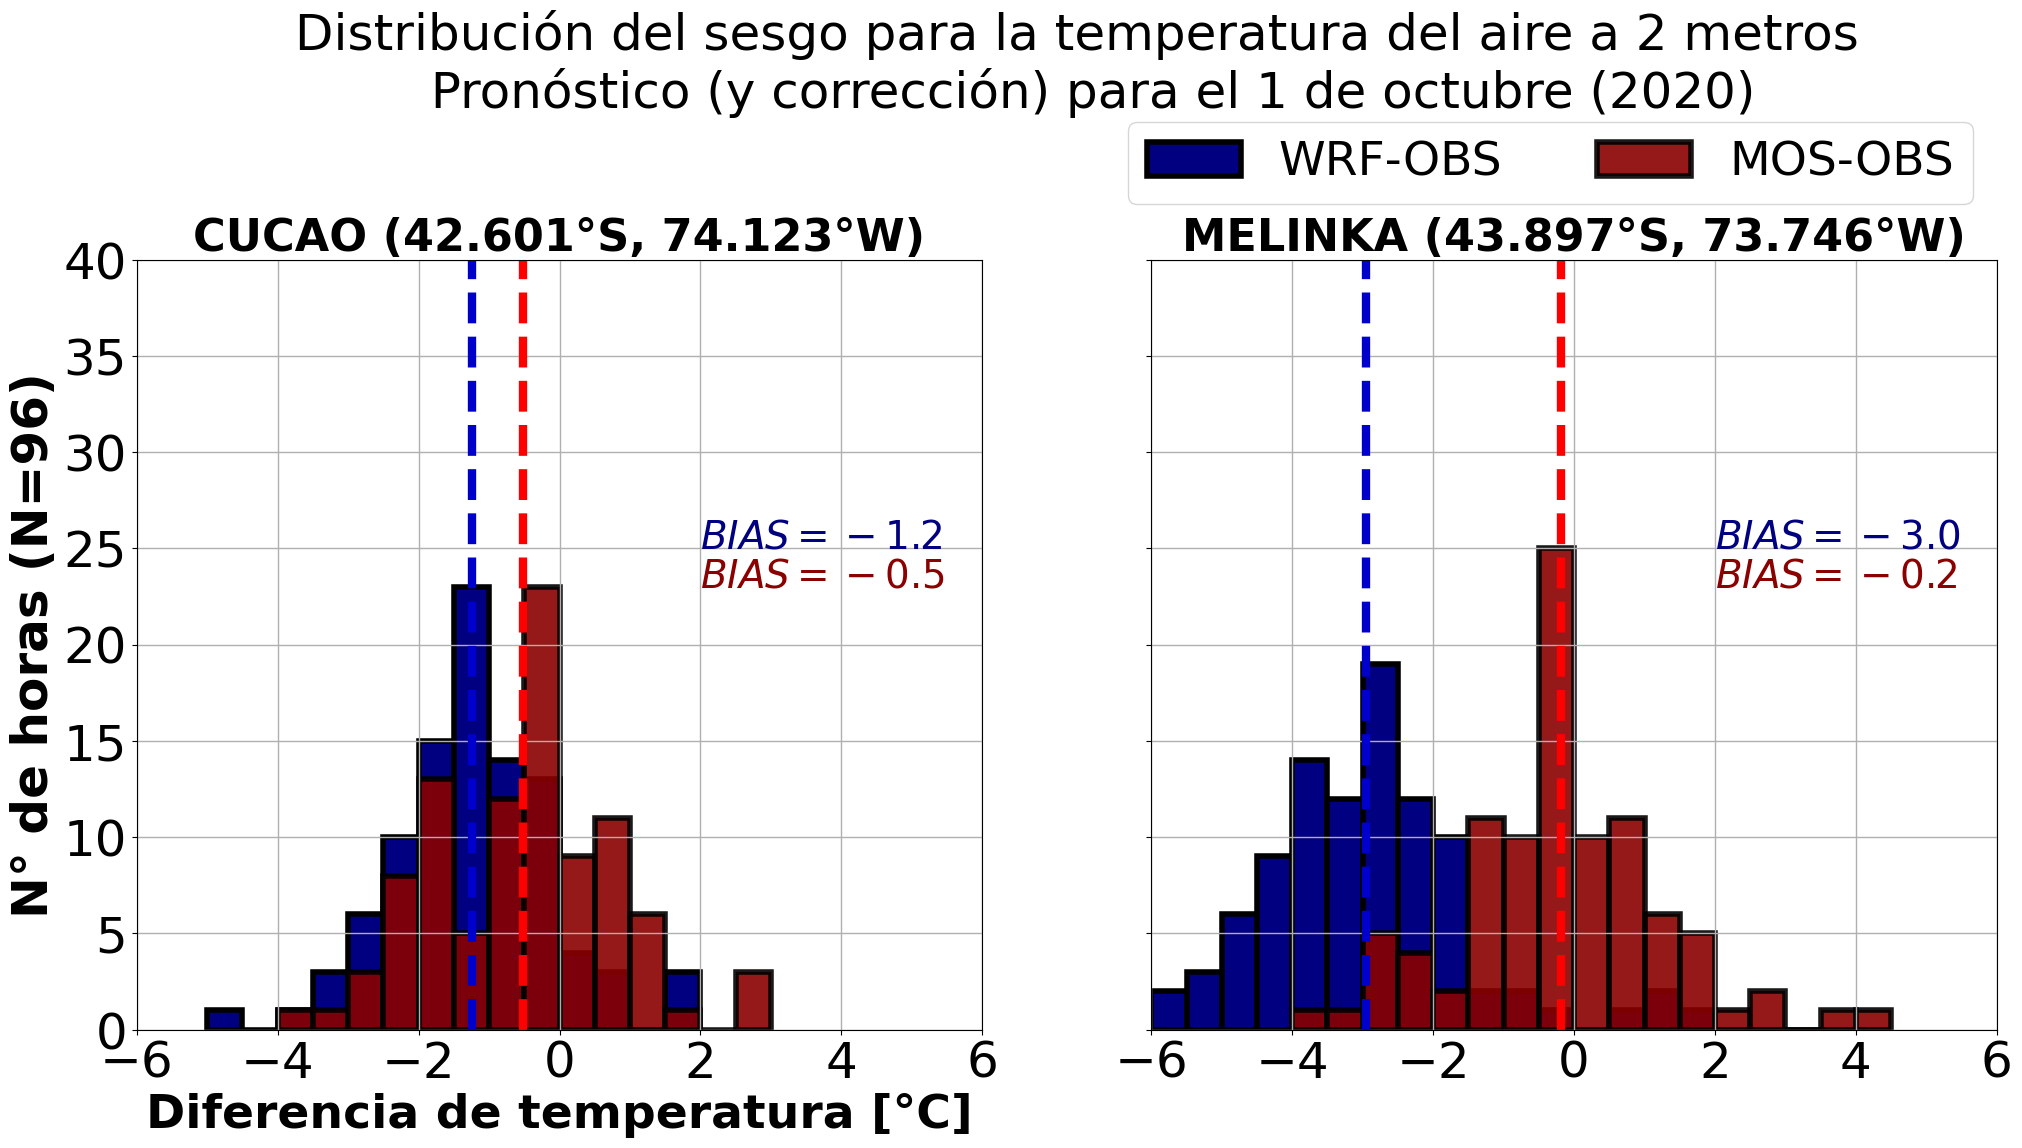

In [18]:
# HISTOGRAMA DE LAS DIFERENCIAS
# ======================================================================================  
fig, ax = plt.subplots(1,2,figsize=(24,10),sharey=True)
fig.suptitle('Distribución del sesgo para la temperatura del aire a 2 metros \n Pronóstico (y corrección) para el 1 de octubre (2020)',x=0.52,y=1.13,fontsize=36)

plt.subplot(1,2,1) # DIFERENCIA DE TEMPERATURA
plt.hist(CUCAO_y_sim-CUCAO_y_test, bins = [-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],color = "navy",edgecolor='k',alpha=1,linewidth=4,label='WRF-OBS')
plt.axvline((CUCAO_y_sim-CUCAO_y_test).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(CUCAO_y_pred-CUCAO_y_test, bins = [-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3],color = "darkred",edgecolor='k',alpha=0.90,linewidth=4,label='MOS-OBS')
plt.axvline((CUCAO_y_pred-CUCAO_y_test).mean(), color='red', linestyle='dashed', linewidth=6)
plt.ylabel('N° de horas (N=96)', fontsize=36, weight='bold')
plt.xlabel('Diferencia de temperatura [°C]', fontsize=34, weight='bold')
plt.title('CUCAO (42.601°S, 74.123°W)',fontsize=32,weight='bold')
plt.ylim(0,40); plt.xlim(-6,6) ; plt.legend(bbox_to_anchor=(2.1995, 1.21),fontsize=34,ncol=2)
plt.xticks(fontsize=36);  plt.yticks(fontsize=36);  plt.grid(True,linewidth=1)
plt.text(2, 25, r'$BIAS=-1.2$',fontsize=28,color='navy')
plt.text(2, 23, r'$BIAS=-0.5$',fontsize=28,color='darkred')

plt.subplot(1,2,2) # DIFERENCIA DE TEMPERATURA 
plt.hist(MELINKA_y_sim-MELINKA_y_test, bins = [-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5],color = "navy",edgecolor='k',alpha=1,linewidth=4,label='WRF-OBS')
plt.axvline((MELINKA_y_sim-MELINKA_y_test).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(MELINKA_y_pred-MELINKA_y_test, bins = [-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5],color = "darkred",edgecolor='k',alpha=0.90,linewidth=4,label='MOS-OBS')
plt.axvline((MELINKA_y_pred-MELINKA_y_test).mean(), color='red', linestyle='dashed', linewidth=6)
#plt.xlabel('Temperatura Máxima [°C]', fontsize=30, weight='bold')
plt.title('MELINKA (43.897°S, 73.746°W)',fontsize=32,weight='bold')
plt.ylim(0,40); plt.xlim(-6,6) ;
plt.xticks(fontsize=36);  plt.yticks(fontsize=36);  plt.grid(True,linewidth=1)

plt.text(2, 25, r'$BIAS=-3.0$',fontsize=28,color='navy')
plt.text(2, 23, r'$BIAS=-0.2$',fontsize=28,color='darkred')



plt.savefig('histograma_T2_MOS_OCT2020.png')

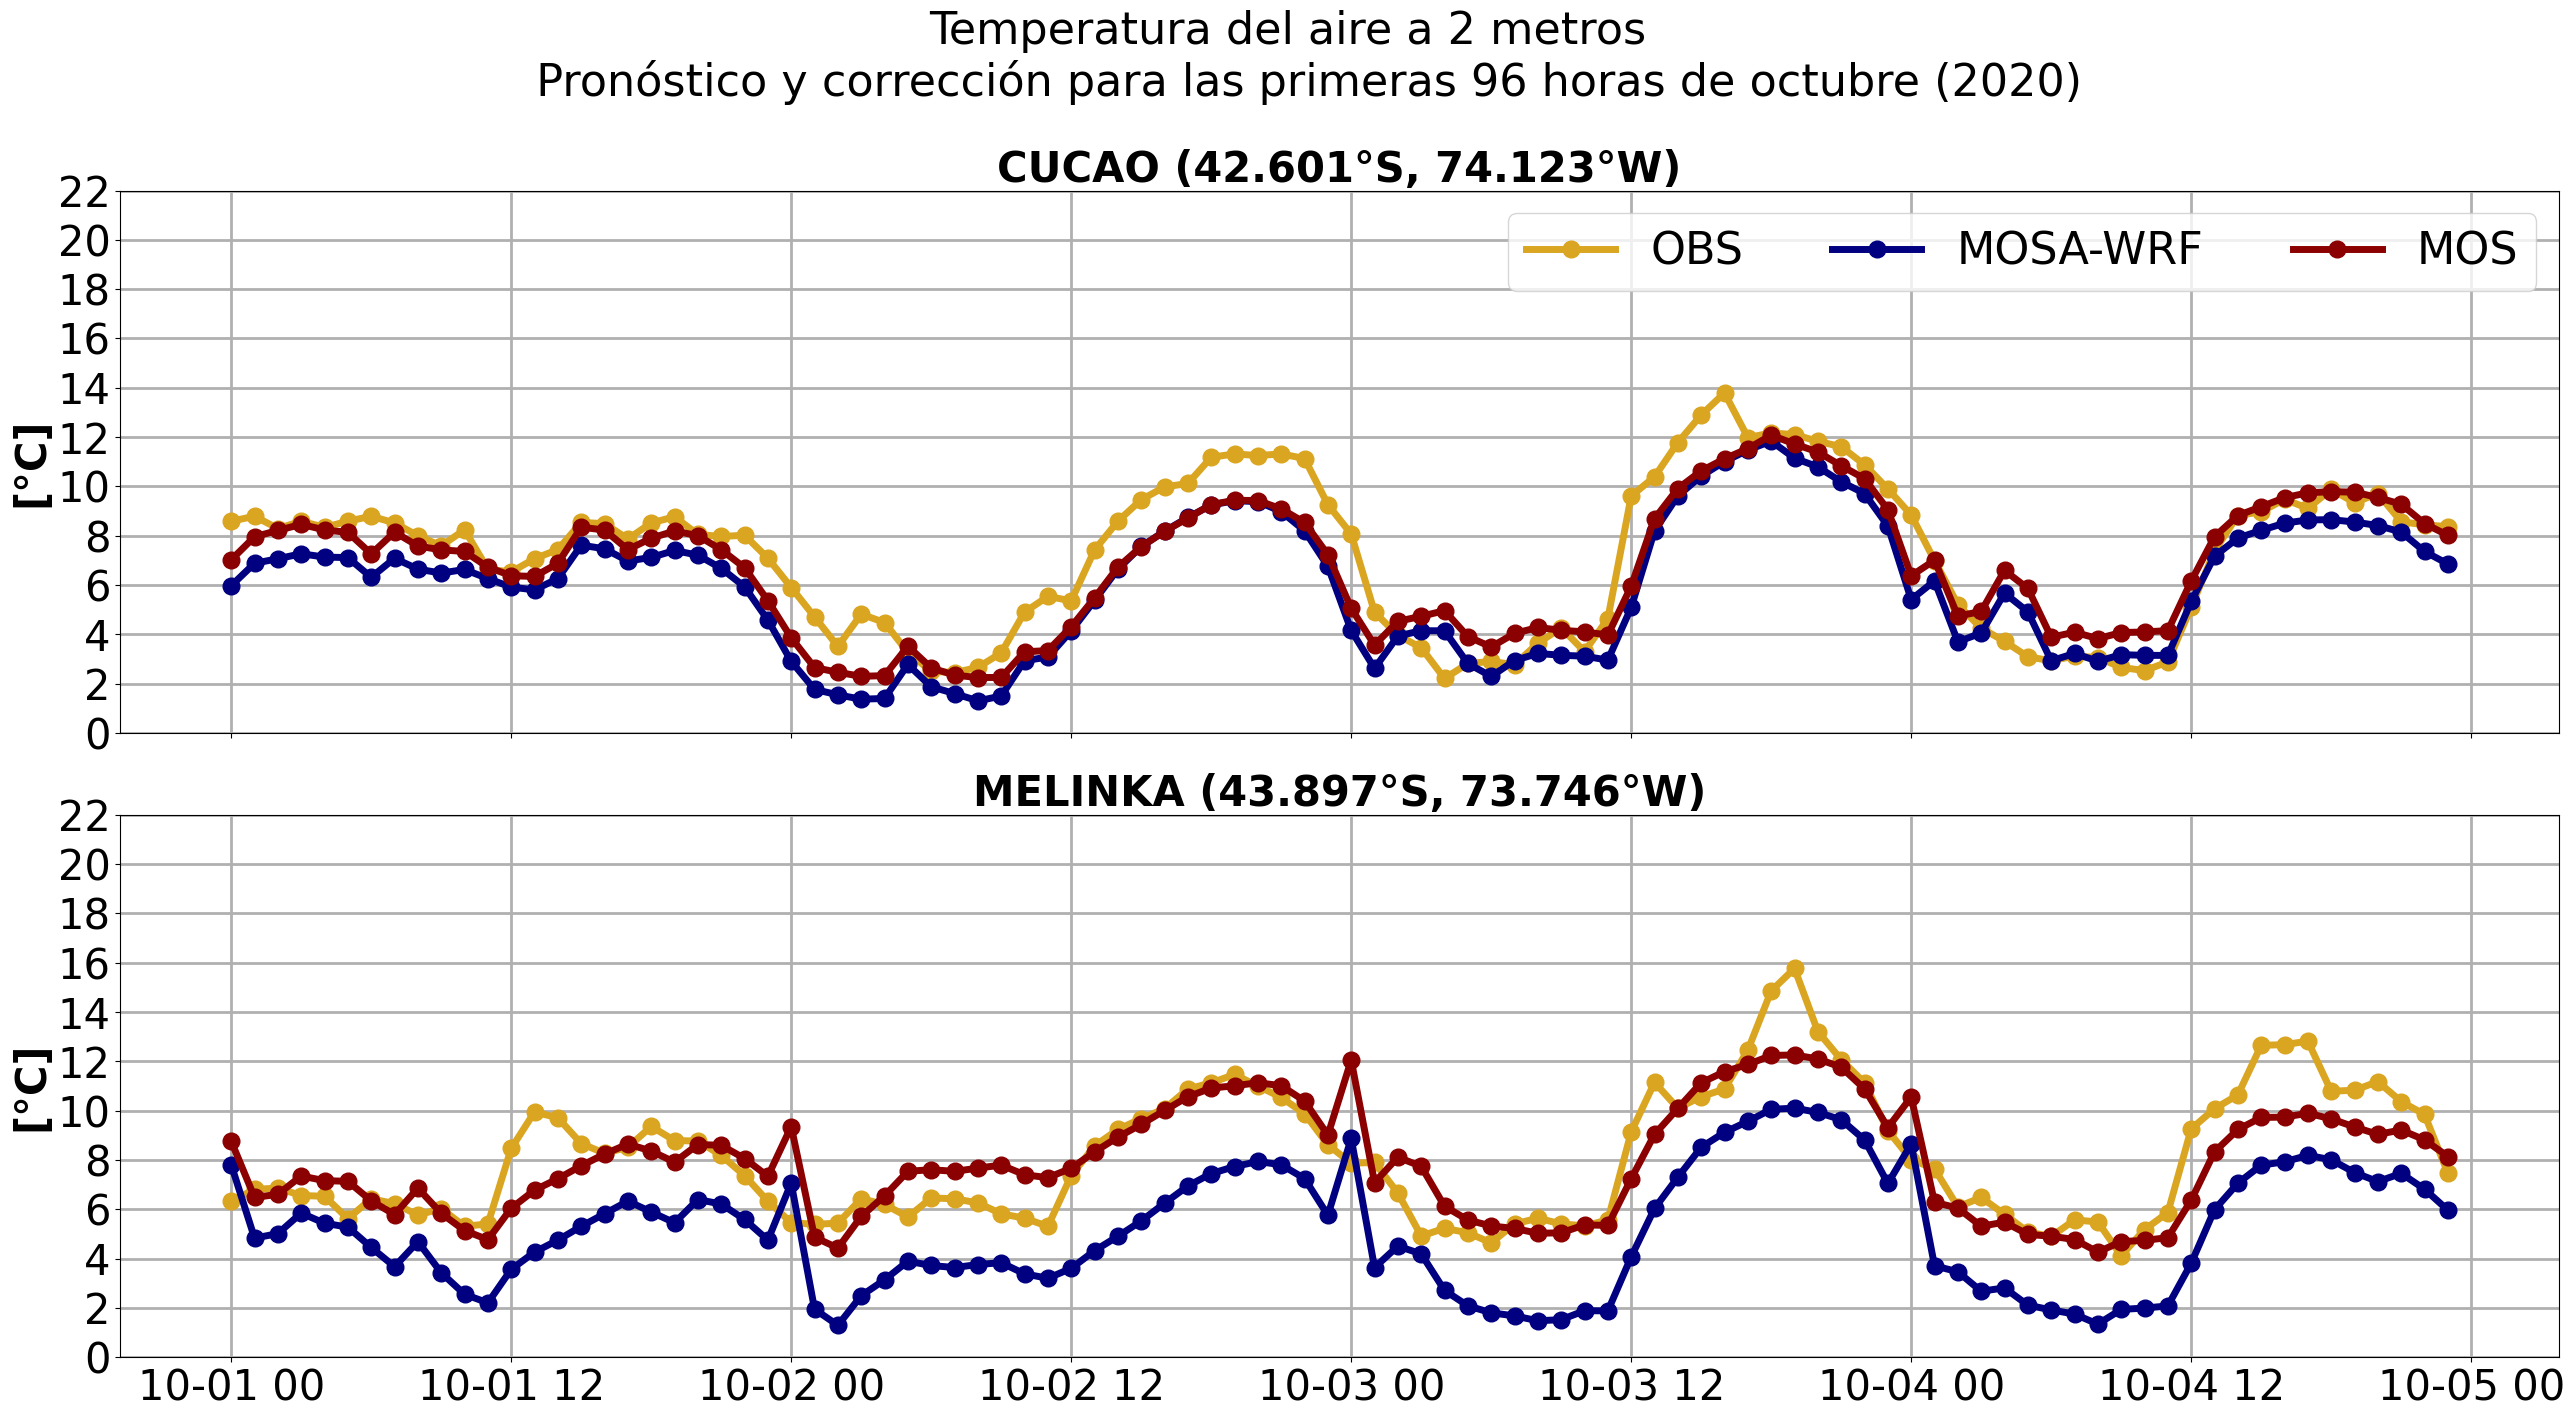

In [19]:
# SERIES DE TIEMPO PARA LA TEMPERATURA DEL AIRE A 2 METROS OBSERVADA, SIMULADA Y AJUSTADA
# ======================================================================================
newtime=pd.Series(pd.date_range(start=f'{2020}-10-1 00:00:00', end=f'{2020}-10-4 23:00:00', freq='H'))

fig, ax = plt.subplots(2,figsize=(26,14), sharex=True)
fig.suptitle('Temperatura del aire a 2 metros \n  Pronóstico y corrección para las primeras 96 horas de octubre (2020)',x=0.5,y=1.01,fontsize=32)
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

# CUCAO
ax[0].plot(newtime,CUCAO_y_test,color='goldenrod',linewidth=5,label='OBS',marker='o',markersize=12) #Observado
ax[0].plot(newtime,CUCAO_y_sim,color='navy',linewidth=5,label='MOSA-WRF',marker='o',markersize=12) #Simulado 
ax[0].plot(newtime,CUCAO_y_pred,color='darkred',linewidth=5,label='MOS',marker='o',markersize=12) #Corregido
ax[0].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[0].set_ylim(0,22)
ax[0].yaxis.set_major_locator(loc)
ax[0].legend(fontsize=32,loc='best',ncol=3)
ax[0].set_title('CUCAO (42.601°S, 74.123°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[0].grid(True,linewidth=2)
# MELINKA
ax[1].plot(newtime,MELINKA_y_test,color='goldenrod',linewidth=5,marker='o',markersize=12) #Observado
ax[1].plot(newtime,MELINKA_y_sim,color='navy',linewidth=5,marker='o',markersize=12) #Simulado 
ax[1].plot(newtime,MELINKA_y_pred,color='darkred',linewidth=5,marker='o',markersize=12) #Corregido
#ax[2].set_xlabel('Fecha', fontsize = 30, weight='bold')
ax[1].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[1].set_ylim(0,22)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('MELINKA (43.897°S, 73.746°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[1].grid(True,linewidth=2)
fig.tight_layout()
plt.savefig("T2_MOS_OCT2020.png")